In [1]:
%pip install pandas matplotlib numpy

Looking in indexes: https://pypi.netflix.net/simple

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Model for headroom estimator for "simple" apps

The goal here is to answer the question, "given an instance type configuration"
(ie: the number of cores), determine what would be a good target utilization.

Important constraints:

- We use no data about the application, historic performance, etc

- We use only instance type information

- We assume that the application is ~single-threaded, or single-flow. Even if
the app hands over between threads, as long as there is no significant parallel
compute, we can treat it here as a single thread.

### Approach:

Using an Erlang-C model, we build an approximate reverse fit that matches what
experience and gut feel tell us "most" applications tend to pick, and err a
little on the side of caution. Then we simplify this into a set of "magic
numbers" in a formula.

### But surely different CPUs have different performance?

Yes, they do, but the goal here is for a reliable and safe solution. We are not
aiming for optimal performance.

- Given response time = service time + wait time

- Assuming service time is approximately linearly improved by faster performance

- Assume at low utilizations wait time is not impactful, and that at very high
utilization wait time dominates and the benefit of improved service time is
relatively less impactful

- We can focus our energy here on estimating the shape of the wait time curve

In addition, we should expect that the faster service time (from faster cores)
would allow the cluster to scale-in, and approach the same utilization.

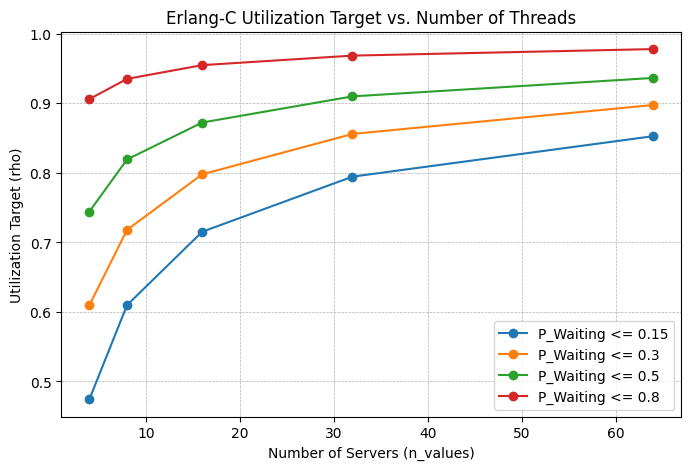

In [2]:
# The Erlang-C formula helps us model how systems behave under load:
# - It calculates the probability of a request having to wait
# - This is crucial for capacity planning: if probability is too high, 
#   users experience delays; if too low, we waste resources

import scipy.special as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the Erlang-C function to compute the probability of waiting
def erlang_c(n, rho):
    """Computes the Erlang-C probability of waiting."""
    if rho >= 1:
        return 1.0  # System is unstable
    num = (n * rho) ** n / sp.factorial(n) * (1 / (1 - rho))
    denom = sum((n * rho) ** k / sp.factorial(k) for k in range(n)) + num
    return num / denom

# Define a function to find the maximum utilization (rho) such that the probability of waiting is within the target
def find_rho(n, target_p_wait=0.15, tol=1e-4):
    """Finds the maximum utilization rho such that P_W <= target_p_wait."""
    low, high = 0, 1 - 1e-6  # Avoid instability at rho = 1
    while high - low > tol:
        mid = (low + high) / 2
        if erlang_c(n, mid) > target_p_wait:
            high = mid
        else:
            low = mid
    return low

# Example usage:
# Define the number of servers (n_values) and target probabilities of waiting (target_p_wait_values)
n_values = [4, 8, 16, 32, 64]
target_p_wait_values = [0.15, 0.30, 0.50, 0.8]  # Multiple target probabilities

# Compute utilization targets for different target_p_wait values
data = []
for target_p_wait in target_p_wait_values:
    rho_values = {n: find_rho(n, target_p_wait) for n in n_values}
    for n, rho in rho_values.items():
        data.append((n, target_p_wait, rho))

# Convert the results to a DataFrame for easier manipulation and plotting
df = pd.DataFrame(data, columns=['n_values', 'target_p_wait', 'utilization_target'])

# Plot the results
plt.figure(figsize=(8, 5))
for target_p_wait in target_p_wait_values:
    subset = df[df['target_p_wait'] == target_p_wait]
    plt.plot(subset['n_values'], subset['utilization_target'], marker='o', linestyle='-', label=f'P_Waiting <= {target_p_wait}')

plt.xlabel('Number of Servers (n_values)')
plt.ylabel('Utilization Target (rho)')
plt.title('Erlang-C Utilization Target vs. Number of Threads')
# plt.xscale('log')  # Log scale for better visualization
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



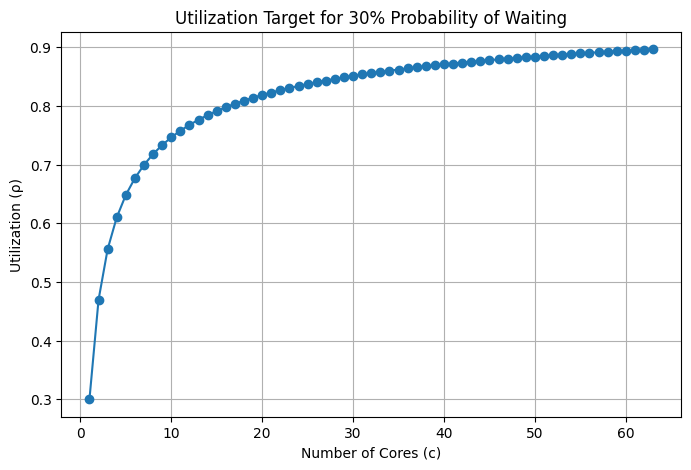

In [3]:

# This cell analyzes how much utilization we can achieve while keeping the probability
# of waiting at 30%. The intuition is:
# - If utilization is too high, requests will queue up and wait too often
# - If utilization is too low, we're wasting resources
# - 30% probability of waiting is a reasonable trade-off based on experience
# 
# The analysis:
# 1. For different numbers of cores (1-64)
# 2. Find the maximum utilization where P(waiting) <= 30%
# 3. Plot the relationship between cores and achievable utilization
# 4. This will help us understand how aggressively we can load different sized instances
#
# The results will show that larger instances can handle higher utilization
# because they have more capacity to absorb temporary spikes in load

def find_utilization_for_wait_prob(c_values, target_p_wait=0.30):
    """Find the utilization (rho) for a given probability of waiting target (p_wait)."""
    rho_values = []
    
    for c in c_values:
        rho_values.append(find_rho(c, target_p_wait))
    
    return rho_values


# Define range of core counts
c_values = np.arange(1, 64)
rho_values = find_utilization_for_wait_prob(c_values, target_p_wait=0.30)

def plot_utilization_vs_cores(c_values, rho_values):
    """Plot utilization vs. number of cores for a given probability of waiting."""
    plt.figure(figsize=(8, 5))
    plt.plot(c_values, rho_values, marker='o', linestyle='-')
    plt.xlabel("Number of Cores (c)")
    plt.ylabel("Utilization (ρ)")
    plt.title("Utilization Target for 30% Probability of Waiting")
    plt.grid(True)
    plt.show()

# Plot the computed values
plot_utilization_vs_cores(c_values, rho_values)

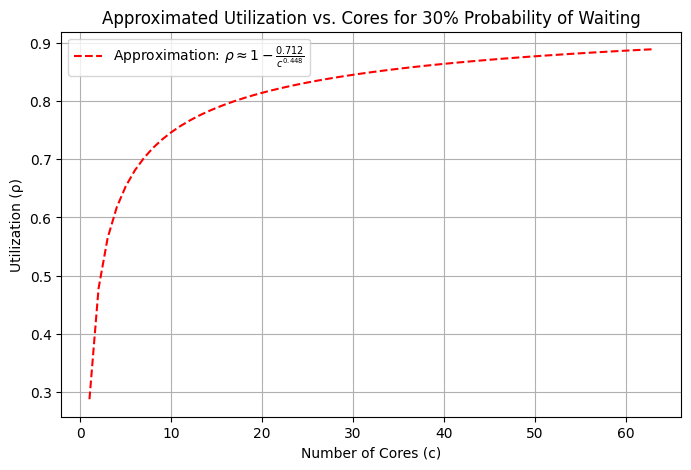

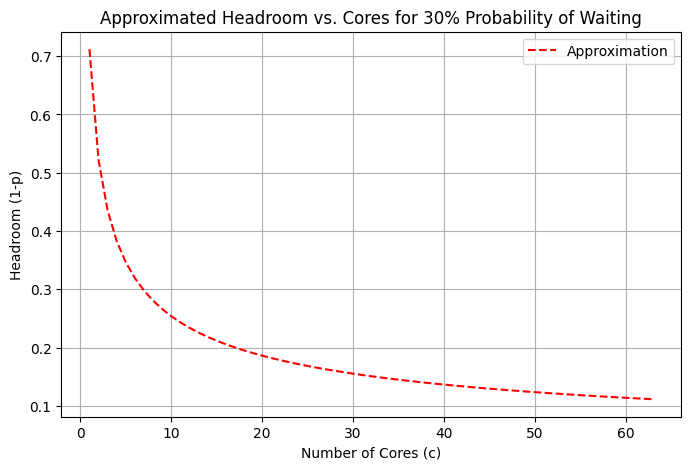

In [4]:
## This code creates an approximate mathematical model for system utilization
## The goal is to find a simple formula that tells us how much CPU capacity to reserve
## based on the number of CPU cores available

# This function estimates the target utilization based on core count
# The formula is derived from fitting to Erlang-C model results
def utilization_approx(c):
    # k and b are empirically derived constants that give a good fit
    # k=0.712 controls the overall scale of the headroom
    # b=0.448 controls how quickly the headroom decreases with more cores
    k, b = 0.712, 0.448
    return 1 - k / (c ** b)

# This function directly calculates how much headroom (spare capacity) we need
# Headroom decreases as we add more cores, but not linearly
# With more cores, we need proportionally less headroom per core
def headroom_approx(c):
    return 0.712 / (c ** 0.448)

# Test our approximation across a range of core counts
c_values = np.arange(1, 64)
rho_approx_values = utilization_approx(c_values)
headroom_approx_values = headroom_approx(c_values)

# Plot the utilization curve
# This shows how much of the CPU we can safely use
plt.figure(figsize=(8, 5))
plt.plot(c_values, rho_approx_values, 'r--', label=r"Approximation: $\rho \approx 1 - \frac{0.712}{c^{0.448}}$")
plt.xlabel("Number of Cores (c)")
plt.ylabel("Utilization (ρ)")
plt.title("Approximated Utilization vs. Cores for 30% Probability of Waiting")
plt.legend()
plt.grid(True)
plt.show()

# Plot the headroom curve
# This shows how much spare capacity we need to keep
# More cores = less headroom needed per core
plt.figure(figsize=(8, 5))
plt.plot(c_values, headroom_approx_values, 'r--', label=r"Approximation")
plt.xlabel("Number of Cores (c)")
plt.ylabel("Headroom (1-p)")
plt.title("Approximated Headroom vs. Cores for 30% Probability of Waiting")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
## Calculate CPU capacity headroom for different scenarios
## This code helps determine how much spare CPU capacity we should maintain
## based on the number of cores and whether hyperthreading is enabled

## Hyperthreading penalty here is a bit of a hack:
## Specifically, hyperthreading does not provide a linear increase in performance
## and the actual performance boost can vary based on the workload. For this
## chart we are assuming WAIT time though, not service time, and HT affects
## service time. So why consider HT at all? The simple answer is that HT does
## increase variance in service time significantly as utilization increases,
## which increases our probability of waiting. So we model it as a penalty
## to reflect the increased probability of waiting due to increased variance.

# Define number of physical cores
n = 32

# Hyperthreading performance penalty
# When hyperthreading is enabled, each core is not as effective as a physical core
# We estimate each virtual core to be about 60% as effective as a physical core
ht_penalty = 0.6

def headroom_approx(cores, is_ht):
    # Adjust effective cores if hyperthreading is enabled
    # This accounts for the reduced effectiveness of virtual cores
    if is_ht:
        cores = cores * ht_penalty
    
    # Calculate required headroom using magic formula:
    return 0.712 / (cores ** 0.448)

# Calculate headroom for both scenarios:
# 1. Physical cores only
# 2. With hyperthreading enabled (effectively more but weaker cores)
print(headroom_approx(n, False))  # Headroom needed with physical cores only
print(headroom_approx(n, True))   # Headroom needed with hyperthreading enabled

0.15072066560052982
0.18947898218236114
